## Imports

In [1]:
import sys
import os
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## 0. Data Cleaning

This first part of the notebook shows all the data cleaning steps. It has to be run once to obtain the cleaned data.

### 0.1 Data Cleaning: Movie Datasets

For our analysis, we will need 2 movie datasets: CMU Movies Dataset & Kaggle Movies Dataset. \
\
<b>Why 2 datasets ?</b> \
\
For our purpose, we need movie data and corresponding movie plots (CMU movie metadata & CMU plot summaries respectively). We will then restrict the analysis to American movies, leaving us with approximately half of the original dataset — 20,788 movies. \
Since our aim is to assess the correlation of the data with historical events, the release date is really important. We want to have the precise date, not just the year. However, dropping all rows where the date is not precise will cause us to lose a lot of data, as only 13,335 movies have precise dates. This is where the Kaggle dataset comes in. When the date is not precise, we will try to match the movie with the corresponding from this dataset and extract its date. Using this method, we recover a lot of data and end up with 17,077 movies.

<b>Data preprocessing steps</b> \
We will apply the following pipeline:

<ul>
    <li>load CMU, plots and Kaggle datasets </li>
    <li>CMU data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Check for NaN values in plots</li>
        <li>Merge CMU metadata and plots on Wikipedia ID — take only movies present in both</li>
        <li>Convert plots to lowercase</li>
        <li>Put each column of the movie metadata in the wanted format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
    </ul>
    <li>Kaggle data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Put each column of the movie metadata in the correct format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
        <li>Drop NaN values and duplicated rows (if present)</li>
    </ul>
    <li>For incomplete or missing dates, merge with the Kaggle dataset using the movie title, and ultimately the date</li>
    <li>Check for outliers (e.g., incorrect dates)</li>
    <li>Save the cleaned dataset</li>
</ul>

### 0.2 Data Cleaning: Real World Violence Dataset

<span style="color:red">THIS PART IS STILL TO BE DONE </span>

## 1. Load the Data

- load the data
- add multiple indexing
- first processing to have unique index

In [62]:
# Add the project root directory to sys.path
sys.path.append(os.path.abspath("src/data"))

# Now import the DataLoader class
from data_loading import DataLoader

raw = 'data/RAW/'
clean = 'data/CLEAN'

In [3]:
# Loader (see data_loading.py for the code regarding this function)
data_loader = DataLoader(raw,clean)
# Load raw data
CMU_movie_metadata, CMU_plot_summary, GVD_data, Kaggle_movies_metadata = data_loader.load_all_data()


load CMU movie metadata


load plot data


load GVD data


load kaggle movie data



### 1.1 CMU metadata

In [4]:
# Let's have a look at the raw CMU metadata first
CMU_movie_metadata

,Freebase movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"


In [5]:
# We will also have a look at the raw CMU plot summaries
CMU_plot_summary

,Plot
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...


In [6]:
# Drop unnecessary columns in metadata
CMU_movie_metadata.drop(['Freebase movie ID', 'Runtime'], axis=1,inplace=True)

In [7]:
# Check for NAN in the plots
CMU_plot_summary[CMU_plot_summary["Plot"].isna()]

,Plot
Wikipedia movie ID,


In [8]:
# Merge the two datasets
Movie_Data = CMU_movie_metadata.merge(CMU_plot_summary,left_index=True, right_index=True, how='inner')

In [9]:
# Lower case the plot_summaries
Movie_Data['Plot'] = Movie_Data['Plot'].str.lower()

In [10]:
# Convert genres, countries and languages in an understandable format
def extract_data(text):
    # Look for all names using a regex pattern: it matches quoted text appearing after colon
    return ', '.join(re.findall(r'": "([^"]+)"', text))

for name in ['Genres','Countries','Languages'] :
    Movie_Data[name] = Movie_Data[name].apply(extract_data)

In [11]:
# Look for where our movies come from
Movie_Data["Countries"].value_counts() 

Countries
United States of America                                             17774
India                                                                 4628
                                                                      3312
United Kingdom                                                        2284
Japan                                                                 1157
                                                                     ...  
Slovakia, Austria, Greece, Spain                                         1
United States of America, Sweden, United Kingdom, Germany                1
Federal Republic of Yugoslavia                                           1
France, United Kingdom, Sweden                                           1
Kingdom of Great Britain, Japan, England, United Kingdom, Germany        1
Name: count, Length: 1501, dtype: int64

Regarding the countries: we conclude that the majority of CMU movies comes from the US. Hence, we will restrict our analysis to the real world violence in the US, to then correlate it to the movies produced in this country in a relative period of time. Our plan is to investigate both the influence in movie violence on real world crimes and the influence of major violents events in history on "on screen" violence. 

In [12]:
# Keep only American movies
Movie_Data = Movie_Data[Movie_Data['Countries'].str.contains("United States of America", na=False)]

In [13]:
# Look at the shape before any drop for dates
Movie_Data.shape

(20788, 7)

In [14]:
# Find all movies where the date format is incomplete
Movie_Data_date_wrong = Movie_Data[~Movie_Data['Release date'].str.match(r'^\d{4}-\d{2}-\d{2}$', na=False)]

In [15]:
# Number of remaining datapoints if we drop all rows where the date format is incomplete
Movie_Data.shape[0]-Movie_Data_date_wrong.shape[0]

13335

Uhm, not that many movies are left. Let's thus turn to the Kaggle dataset to solve this issue. 

### 1.2 Kaggle metadata

In [16]:
# Let's have a look at the data
Kaggle_movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [17]:
# Keep only the rows of interest
Kaggle_movies_metadata = Kaggle_movies_metadata[["production_countries","release_date","title"]]

In [18]:
# Check again the countries of production (spoiler: it's again the US)
Kaggle_movies_metadata['production_countries'].value_counts()

production_countries
[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                                          17851
[]                                                                                                                                                                   6282
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                                                     2238
[{'iso_3166_1': 'FR', 'name': 'France'}]                                                                                                                             1654
[{'iso_3166_1': 'JP', 'name': 'Japan'}]                                                                                                                              1356
                                                                                                                                 

In [19]:
# Extract country of production for the Kaggle dataset
def extract_country(text):
    final_countries = ""
    countries = ast.literal_eval(Kaggle_movies_metadata.production_countries[0])
    for country in countries :
        final_countries = final_countries + " " + country['name']
    return final_countries 

Kaggle_movies_metadata.loc[:, 'production_countries'] = Kaggle_movies_metadata['production_countries'].apply(extract_country)

In [20]:
# Keep only American movies
Kaggle_movies_metadata = Kaggle_movies_metadata[Kaggle_movies_metadata['production_countries'].str.contains("United States of America", na=False)]
Kaggle_movies_metadata.shape

(45466, 3)

In [21]:
# Drop NAN values
Kaggle_movies_metadata.dropna(inplace=True)
Kaggle_movies_metadata.shape

(45376, 3)

In [22]:
# Drop full duplicates
Kaggle_movies_metadata.drop_duplicates()
Kaggle_movies_metadata.shape

(45376, 3)

### 1.3 Now that we have our two datasets, we can handle the date & duplicates problems

In [23]:
# An example
Movie_Data[Movie_Data["Movie name"] == "Dr. Jekyll and Mr. Hyde"]

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
7884497,Dr. Jekyll and Mr. Hyde,1913-03-06,NaN,English Language,United States of America,"Short Film, Science Fiction, Horror, Black-and...","dr. henry jekyll sends a note to his fiancée,..."
7883633,Dr. Jekyll and Mr. Hyde,1920-04,NaN,"Silent film, English Language",United States of America,"Silent film, Horror, Indie, Science Fiction, B...",at the first transformation starts with jekyll...
144774,Dr. Jekyll and Mr. Hyde,1931-12-31,NaN,English Language,United States of America,"Science Fiction, Horror, Black-and-white, Dram...","the film tells the story of dr. henry jekyll ,..."
3672796,Dr. Jekyll and Mr. Hyde,1920-03-18,NaN,"Silent film, English Language",United States of America,"Crime Fiction, Silent film, Horror, Science Fi...","henry jekyll is a doctor of medicine, but he ..."
2490751,Dr. Jekyll and Mr. Hyde,1941-08-12,1279000.0,English Language,United States of America,"Science Fiction, Horror, Black-and-white",dr. jekyll believes good and evil exist in ev...
7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,NaN,Silent film,United States of America,"Short Film, Silent film, Horror, Indie, Black-...",dr. jekyll and mr. hyde began with the raising...
7856323,Dr. Jekyll and Mr. Hyde,1912-01-16,NaN,English Language,United States of America,"Short Film, Horror, Black-and-white",james cruze's white-haired dr. jekyll has secr...


In [24]:
Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == "Dr. Jekyll and Mr. Hyde"]

,production_countries,release_date,title
7055,United States of America,1941-08-12,Dr. Jekyll and Mr. Hyde
7823,United States of America,1931-12-31,Dr. Jekyll and Mr. Hyde
8294,United States of America,1920-03-18,Dr. Jekyll and Mr. Hyde
25134,United States of America,2008-05-17,Dr. Jekyll and Mr. Hyde


As we can see, some names are similar in both datasets, but there is no duplicate. They are different movies. \
We will take that into account for the date algorithm. 

In [25]:
# Iter on all rows of the wrong date dataset
for index, row in Movie_Data_date_wrong.iterrows() :
    # Is it in the Kaggle dataset ?
    kaggle_data = Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == row["Movie name"]]
    
    # If not, drop the row
    if kaggle_data.empty :
        #print("drop")
        Movie_Data.drop([index], inplace=True)

    # If yes and only one, extract the date
    elif kaggle_data.shape[0] == 1 :
        #print("change")
        Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

    # If multiple movies have this name in the Kaggle dataset, compare with the incomplete date of the CMU dataset
    else :
        date = Movie_Data_date_wrong.loc[index, "Release date"]

        # If not the same year and not the year in the CMU, drop
        if pd.isna(date) or len(date) < 4 :
            Movie_Data.drop([index],inplace=True)

        # Else, compare
        else :
            kaggle_data = kaggle_data[kaggle_data['release_date'].str[:4] == date[0:4]]

            # Found only 1 movie this year ? extract the date !
            if kaggle_data.shape[0] == 1 :
                #print("found!")
                Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

            # Give up
            else :
                #print("sad..")
                Movie_Data.drop([index], inplace=True)

In [26]:
Movie_Data 
# Nice we kept 4000 more data !

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
6631279,Little city,1997-04-04,NaN,English Language,United States of America,"Romantic comedy, Ensemble Film, Comedy-drama, ...","adam, a san francisco-based artist who works a..."
77856,Mary Poppins,1964-08-27,102272727.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",the film opens with mary poppins perched in a...
21926710,White on Rice,2009-05-31,NaN,,United States of America,"Romantic comedy, Romance Film, Comedy, Indie",jimmy ([[hiroshi watanabe loves dinosaurs and...
156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...
...,...,...,...,...,...,...,...
25011340,Dot.Kill,2005-03-08,NaN,,United States of America,"Thriller, Crime Thriller, Action, Psychologica...","charlie daines , is a morphine-addicted detect..."
7761830,Spaced Invaders,1990-04-27,15369573.0,English Language,United States of America,"Alien Film, Science Fiction, Family Film, Come...","the space armada from mars, known as the imper..."
1918494,State and Main,2000-08-26,6944471.0,"Italian Language, English Language","France, United States of America","Parody, Americana, Comedy",havoc is wrought on the inhabitants of a small...


In [27]:
# We are thus left with:
print("We are thus left with: {} movies.".format(len(Movie_Data)))

We are thus left with: 17077 movies.


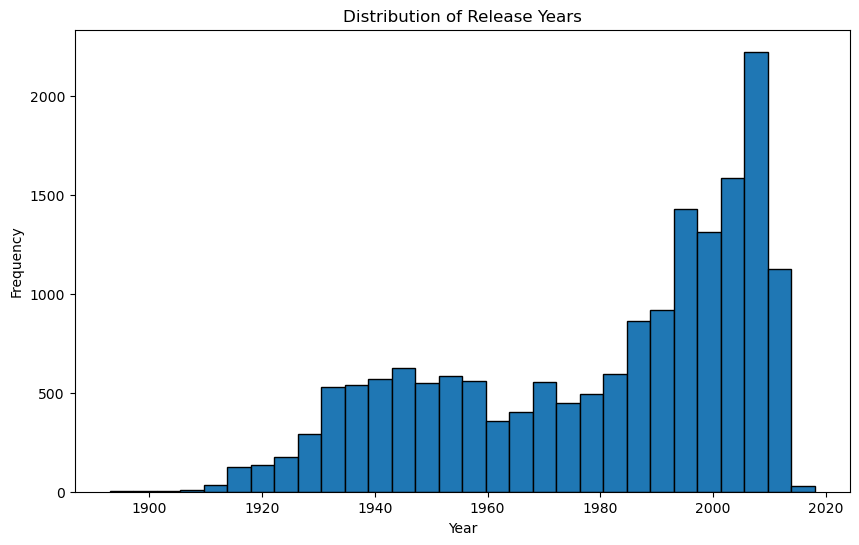

In [28]:
Date = Movie_Data["Release date"].str[:4].astype(int)
plt.figure(figsize=(10, 6))
plt.hist(Date, bins=30, edgecolor='black')
plt.title('Distribution of Release Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# Looks nice ! no outliers :)

In [29]:
# Save the data 
Movie_Data.to_csv(clean+"/Movie_Data_clean.tsv", sep="\t")

## 2. Plot analysis

Now starts the characterization of our movies. First, we want to look into the plots and count how many violent words appear in the summary. \
Here, two things are worth notice: 
1. The list of words is souced from the web and agumented by us, for more completeness. Therefore, there is some subjectivity on our violence score: it depends on which terms we added. To know more about it see <span style="color:red"> file txt</span>. 
2. The summaries are not all the same length. Hence, we use the density of violent words in the plots to characterize violence. 

Here we start with the generic list of violent words. Then we will have a list for words related to psychological violence.

### 2.1 Generic violent words

In [30]:
# Let's have a look at the selected words for our first list (physical violence)
violent_word_list = data_loader.Violent_word_list("Physical_violence")
print(violent_word_list)

['assassination', 'assault', 'attack', 'behead', 'beheading', 'beat', 'beating', 'bludgeon', 'blood', 'bloody', 'bomb', 'bombing', 'box', 'boxing', 'brutalize', 'bullet', 'butcher', 'choke', 'combat', 'corpse', 'crush', 'decapitate', 'decapitation', 'dismember', 'dismemberment', 'enemy', 'execute', 'execution', 'explode', 'explosion', 'fist fight', 'gore', 'gory', 'gun', 'gun down', 'gunshot', 'hack', 'hang', 'hit', 'homicide', 'impale', 'injure', 'injury', 'kill', 'killing', 'knife', 'knifing', 'maim', 'manslaughter', 'massacre', 'molest', 'murder', 'mutilate', 'mutilation', 'punch', 'rape', 'ravage', 'rip', 'savage', 'sever', 'shoot', 'shooting', 'slash', 'slay', 'slaying', 'slaughter', 'slit', 'smash', 'stab', 'stabbing', 'strangle', 'strangulation', 'suffocate', 'suffocation', 'throttle', 'torture', 'trample', 'wound', 'artillery', 'bombardment', 'shelling', 'ambush', 'grenade', 'mortar', 'bayonet', 'napalm', 'landmine', 'shrapnel']


In [31]:
# We put the list to a Pandas Dataframe
violence_list = pd.DataFrame(violent_word_list)

In [32]:
# We create an excel out of the list, so that if we want to modify it later we don't need to come back inside the code
# violence_list.to_excel(clean+"/violent_word_list/Physical_violence.xlsx", index=False,header=False)

### 2.2 Violent words related to psychology

In [33]:
# Let's have a look at the selected words for our second list (psychological violence)
psycho_violence_list = data_loader.Violent_word_list("Psychological_violence")
print(psycho_violence_list)

['abandoned', 'abandoning', 'abandonment', 'abuse', 'abused', 'abusing', 'abusive', 'agitate', 'agitated', 'agitating', 'agony', 'alienate', 'alienated', 'alienating', 'amnesia', 'anger', 'angry', 'anguish', 'animalistic', 'antagonise', 'antagonize', 'attack', 'attacked', 'attacking', 'anxious', 'avoid', 'avoided', 'avoiding', 'backhanded', 'belittle', 'belittled', 'belittling', 'betray', 'betrayal', 'betrayed', 'betraying', 'blackmail', 'blackmailed', 'blackmailing', 'blame', 'blamed', 'blame-shifting', 'blaming', 'brainwash', 'brainwashed', 'brainwashing', 'break', 'breaking', 'broken', 'bully', 'bullied', 'bullying', 'catastrophise', 'catastrophize', 'catastrophising', 'catastrophizing', 'chaos', 'condescending', 'condescendent', 'condition', 'conditional', 'control', 'controlled', 'controlling', 'criticism', 'criticise', 'criticize', 'criticised', 'criticized', 'criticising', 'criticizing', 'cruel', 'cruelty', 'damaging', 'deceive', 'deceit', 'deceptive', 'defame', 'demean', 'demea

In [34]:
# We put the list to a Pandas Dataframe
psycho_list = pd.DataFrame(psycho_violence_list)

In [35]:
# We create an excel out of the list, so that if we want to modify it later we don't need to come back inside the code
#psycho_list.to_excel(clean+"/violent_word_list/Psychological_violence.xlsx", index=False,header=False)

### 2.3 Analysis of the outcome of violent words density in summary

In [36]:
# We use the WordCounter class to investigate the density of violent words in the summaries

sys.path.append(os.path.abspath("src/model"))

# Now you can import the script like a module
from Word_counter import WordCounter

For Wordcounter see file Word_counter.py. We can either use one list only, with the keywords _Physical_violence_ & _Psychological_violence_, or all lists with keyword _All_. Note that, with this method if non-existing keywords are given as inputs, the 

In [37]:
Word_Counter = WordCounter(data_loader, Movie_Data)

In [38]:
# Let's look at the count of violent words (both )
Count_violent = Word_Counter.violent_word_count("All")

word count for the list : Physical_violence
word count for the list : Psychological_violence
total count
calculate density
done !


In [39]:
# We look at our results
Count_violent

,word_count_Physical_violence,word_count_Psychological_violence,total_count,density word_count_Physical_violence,density word_count_Psychological_violence
Wikipedia movie ID,,,,,
3217,3,3,479,0.006263,0.006263
3333,1,5,858,0.001166,0.005828
3746,3,3,669,0.004484,0.004484
3837,7,3,631,0.011094,0.004754
3947,7,7,930,0.007527,0.007527
...,...,...,...,...,...
36956792,6,2,780,0.007692,0.002564
37067980,0,0,50,0.000000,0.000000
37210334,1,1,259,0.003861,0.003861


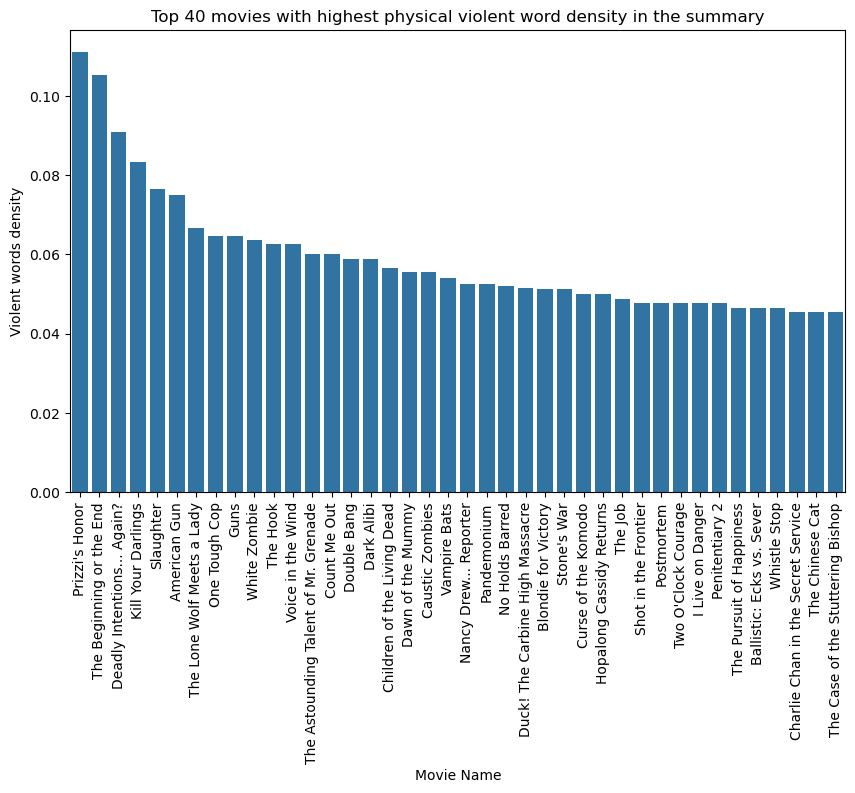

In [40]:
# Let's plot the 40 most violent (physically) movies 

# First we sort the values
Count_violent_sorted_physical = Count_violent.sort_values(by='density word_count_Physical_violence', ascending=False)

# We retreive the movie name from the Movie_Data dataframe
indices_physical_violence = Count_violent_sorted_physical.head(40).index
movie_names = Movie_Data.loc[indices_physical_violence, 'Movie name']
density_physical_violence = Count_violent_sorted_physical.head(40)['density word_count_Physical_violence']

plt.figure(figsize=(10, 6))
sns.barplot(x=movie_names, y=density_physical_violence)
plt.xlabel("Movie Name")
plt.ylabel("Violent words density")
plt.title("Top 40 movies with highest physical violent word density in the summary")
plt.xticks(rotation=90)
plt.show()

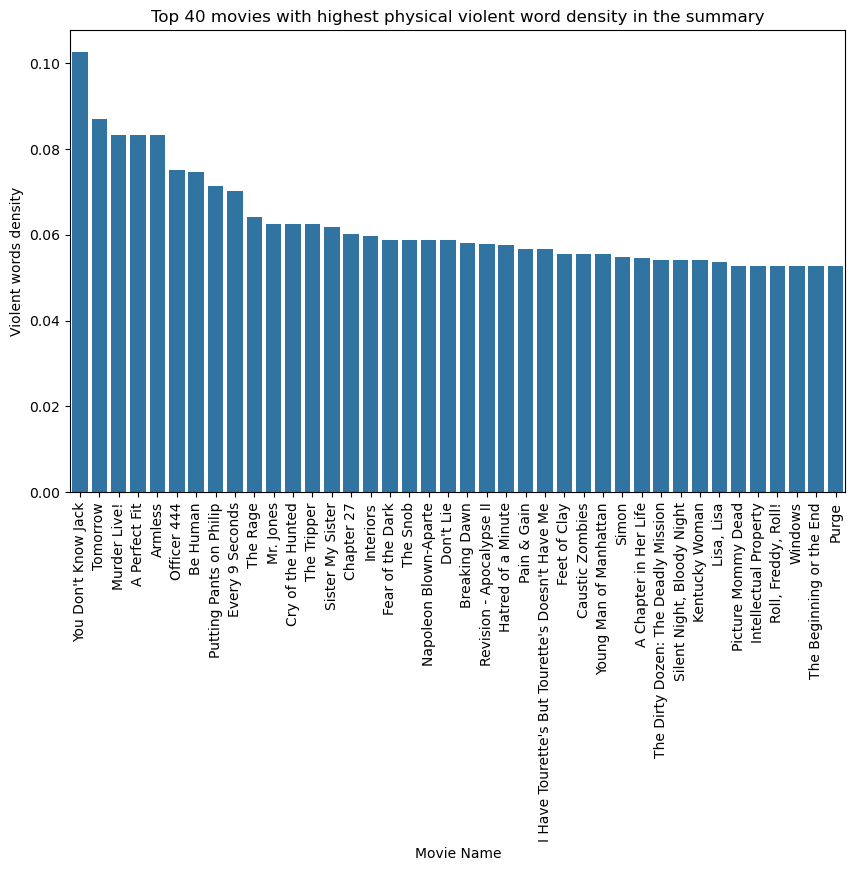

In [41]:
# Let's plot the 40 most violent (psychologically) movies 

# First we sort the values
Count_violent_sorted_psycho = Count_violent.sort_values(by='density word_count_Psychological_violence', ascending=False)

# We retreive the movie name from the Movie_Data dataframe
indices_psycho_violence = Count_violent_sorted_psycho.head(40).index
movie_names = Movie_Data.loc[indices_psycho_violence, 'Movie name']
density_psycho_violence = Count_violent_sorted_psycho.head(40)['density word_count_Psychological_violence']

plt.figure(figsize=(10, 6))
sns.barplot(x=movie_names, y=density_psycho_violence)
plt.xlabel("Movie Name")
plt.ylabel("Violent words density")
plt.title("Top 40 movies with highest physical violent word density in the summary")
plt.xticks(rotation=90)
plt.show()

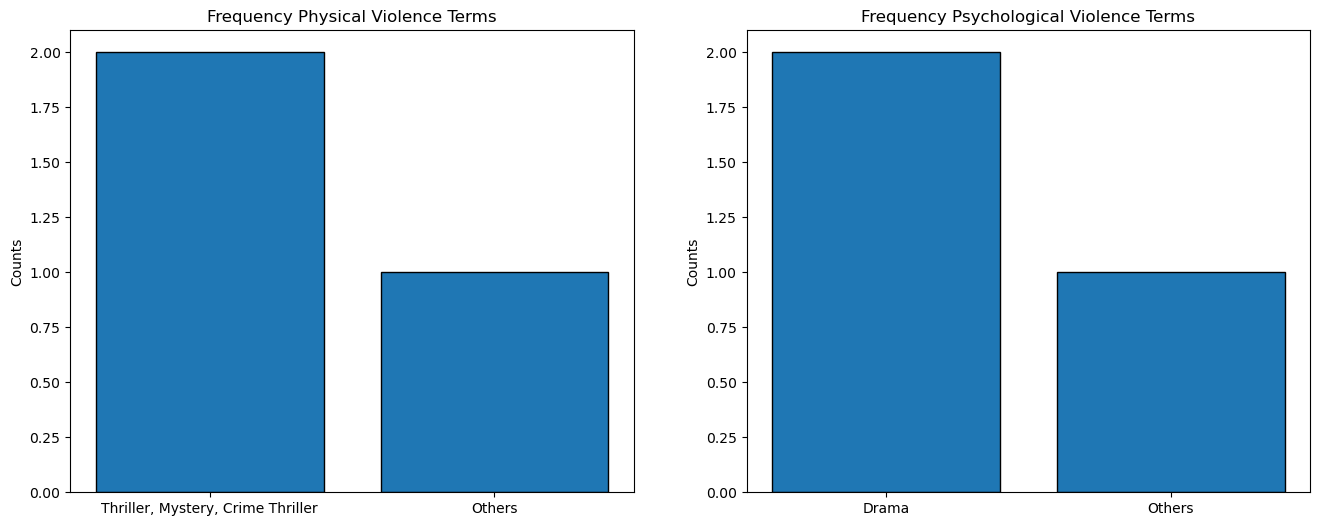

In [42]:
# We retreive the genre for most physically & psychologically violent movies

# Count genres appearances
movie_genres_physical = Movie_Data.loc[indices_physical_violence, 'Genres'].value_counts()
movie_genres_psycho = Movie_Data.loc[indices_psycho_violence, 'Genres'].value_counts()

# Group by the counts
genres_physical_more_once = movie_genres_physical[movie_genres_physical > 1]
genres_physical_once = movie_genres_physical[movie_genres_physical == 1]

genres_psycho_more_once = movie_genres_psycho[movie_genres_psycho > 1]
genres_psycho_once = movie_genres_psycho[movie_genres_psycho == 1]

# Prepare for plotting
labels_physical = list(genres_physical_more_once.index) + ["Others"]
heights_physical = list(genres_physical_more_once.values) + [1]

labels_psycho = list(genres_psycho_more_once.index) + ["Others"]
heights_psycho = list(genres_psycho_more_once.values) + [1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.bar(labels_physical, heights_physical, edgecolor='black')
ax1.set_ylabel('Counts')
ax1.set_title('Frequency Physical Violence Terms')

ax2.bar(labels_psycho, heights_psycho, edgecolor='black')
ax2.set_ylabel('Counts')
ax2.set_title('Frequency Psychological Violence Terms')
plt.show()



## 3. How to classify movies into violent or non-violent? 

Now that we have a better idea of what our movies look like from the analysis of their plot, we would like to classify them into non-violent, mild and violent. \
To do that, we will use surely the results previously obtained from the plots. However we ask ourselves: how do we combine the results from the psychological violence and the physical violence terms? \
To answer this question we decided to include a sentiment analysis of our plots, and to use the latter together with the results obtained from the plots to create a regression model. By doing this we can infer the weights of each feature for our model. Hence, we humanly-labelled 100 summaries and used those as training set. 

### 3.1 Sentiment Analysis

In this section, we will apply the DistillBERT sentiment analysis model to the clean dataset and save the result.

In [46]:
# First: we load the labelled the data
ViolentLabel,ViolentData = data_loader.human_labelled_data("Raw")
display(ViolentLabel)
display(ViolentData.head())

/opt/anaconda3/envs/alligators/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


,Violence level,Label
0,Low,-1
1,Medium/not sure,0
2,Violent,1


,Answer,Date
Wikipedia movie ID,,
19286405,0,11.11
6714641,1,11.11
27573594,1,11.11
25874731,0,11.11
34954266,-1,11.11


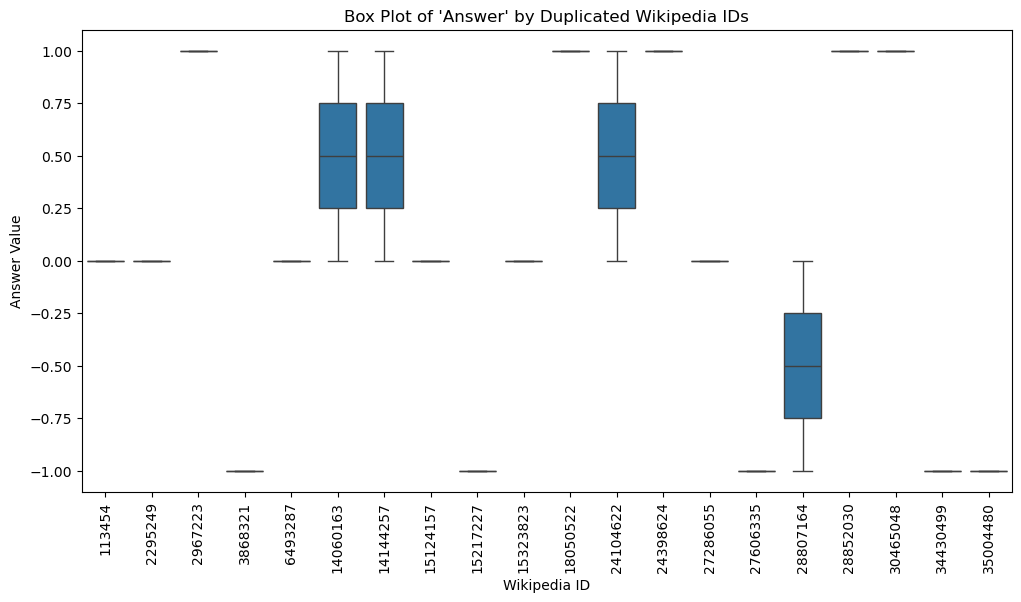

In [47]:
duplicated_data = ViolentData[ViolentData.index.duplicated(keep=False)]

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=duplicated_data, x="Wikipedia movie ID", y="Answer")

# Add labels and title
plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [48]:
print("We have",len(ViolentData.index.unique()),"labelled plots")
print("We have",len(duplicated_data.index.unique()),"duplicated labelling")
print("We have",(duplicated_data.groupby("Wikipedia movie ID")["Answer"].nunique() > 1).sum(),"datapoint with different labels")

We have 50 labelled plots
We have 20 duplicated labelling
We have 4 datapoint with different labels


In [49]:
ViolentData = ViolentData.groupby("Wikipedia movie ID").mean()

In [50]:
data_loader.save_back_to_excel(ViolentLabel, ViolentData)

<span style="color:red">distillBERT sentiment analysis: ici il faut qu'on phrase pk cette partie est commentée</span>

In [55]:
sys.path.append(os.path.abspath("src/model"))

## Import the script like a module
import DistillBERT_emotion

In [57]:
# Load raw data
data_loader = DataLoader(raw,clean)

# Are we working on the test set
Test_set_data = True
# Run everything again ? 
Run = False

if Test_set_data :
    MovieData = data_loader.plot_data()
    MovieName = data_loader.movie_data()["Movie name"]
    ViolentLabel, ViolentData = data_loader.human_labelled_data()
    MovieData = MovieData.loc[ViolentData.index.unique()]
    MovieData = pd.merge(MovieData,MovieName, left_index=True, right_index=True,how="inner")
else :
    MovieData = data_loader.clean_movie_data()


load plot data


load CMU movie metadata



In [58]:
MovieData.head()

,Plot,Movie name
Wikipedia movie ID,,
113454,The film tells the story of a mob hit man and...,Prizzi's Honor
2295249,Theresa is one of the twelve jurors who have t...,A Killer Among Us
2967223,Robert Crain is a German pacifist living in In...,Morituri
3868321,"Zach is a soul collector, an angel who collec...",The Soul Collector
4481850,"Adam, a 23-year-old self-employed security tec...",Straightheads


In [59]:
if Run :
    # Lists to accumulate rows for efficiency
    sentiment_data = []
    
    detector = DistillBERT_emotion.ViolenceDetector()
    i = 0
    for index,row in MovieData.iterrows():
        if i%1000 ==0:
            print(i)
        result = detector.analyze_violence(row["Plot"])
    
        sentiment_data.append({
                "Wikipedia movie ID": index,
                "name" : row["Movie name"],
                "sadness": result[0],
                "joy": result[1],
                "love": result[2],
                "anger": result[3],
                "fear": result[4],
                "surprise": result[5]
            })
        i += 1
    
    Sentiment = pd.DataFrame(sentiment_data)

In [63]:
if Run : 
    # Save the result
    if Test_set_data : 
        Sentiment.to_csv(clean + "/sentiment_test.csv") 
    else : 
        Sentiment.to_csv(clean + "/sentiment.csv") 
else :
    SentimentData, SentimentDataTest = data_loader.load_sentiment()
    if Test_set_data :
        Sentiment = SentimentDataTest
    else :
        Sentiment = SentimentData

FileNotFoundError: [Errno 2] No such file or directory: 'data/CLEAN/sentiment_test.csv'

In [54]:
Sentiment = Sentiment.set_index("Wikipedia movie ID")
Sentiment.head()

NameError: name 'Sentiment' is not defined

In [ ]:
# Sentiment analysis using DistillBERT_emotion

X = 30
emotions = ["sadness",
            "joy",
            "love",
            "anger",
            "fear",
            "surprise"]

# Create a figure with subplots (1x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(16,12))

# Set a title for the entire figure
fig.suptitle('Top Emotion Scores for Movies', fontsize=16)

for i in range(0,len(emotions)):
    
    # Plot for Sadness with vertical x labels
    sns.barplot(x='name', y=emotions[i], data=Sentiment.sort_values(emotions[i],ascending=False).iloc[0:min(X,Sentiment.shape[0])],ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Top {emotions[i].capitalize()} Scores')
    axes[i//3, i%3].set_xlabel('Movie ID')
    axes[i//3, i%3].set_ylabel(f'{emotions[i].capitalize()} Score')

    axes[i//3, i%3].set_xticks(range(min(X,Sentiment.shape[0])))  # Ensure ticks are set
    axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=90)


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.show()

### 3.2 Violent movies finder: the regression model

<b> First step: labelling the Data </b> \
Since labeled data is required for analysis, we manually labeled a subset of the dataset. We divided part of the data among team members and, to ensure the subjectivity of the labeling process, we had some plots labeled multiple times by external participants. Each movie plot was classified based on a categorical scale:
<ul>
    <li><b>-1</b> : non-violent movies</li>
    <li><b>0</b> : possibly slightly violent or uncertain</li>
    <li><b>1</b> : definitely violent movies</li>
</ul>


<b> The Model </b> \
For simplicity, we chose to perform a logistic regression using several selected features.


<b> The features </b> \
The selected feature set includes:
<ul>
    <li><b>Word Count Features</b>
        <ul> 
            <li>Count of physically violent words</li> 
            <li>Count of psychologically violent words</li> 
            <li>Density of physically violent words</li> 
            <li>Density of psychologically violent words</li>
        </ul>
    </li>
    <li><b>Sentimental Analysis Features</b>
       <ul>
           <li>Sadness</li>
           <li>Joy</li>
           <li>Love</li>
           <li>Anger</li>
           <li>Surprise</li>
       </ul>
    </li>
</ul>



<b> The Dataset </b> 
<ul>
    <li><b>Training and Testing Data</b> <br/> Given the limited number of labeled plots available, we will use most of the labeled items for the training set. We will keep five plots as the testing set to evaluate the model (alternatively, we may use the entire dataset and assess labeling quality across the final labeled set) </li>
    <li><b>Final Dataset</b>  <br/> We will apply the model to label the entire dataset and review the quality of the labels.</li>
</ul>

In [ ]:
# Load the data
data_loader = DataLoader(raw,clean)
MovieData,DataTest = data_loader.data_for_violent_model()
MovieData.head()

### Let's have a look at human labelled subjectivity

In [ ]:
# Load the labelled data
ViolentLabel,ViolentData = data_loader.human_labelled_data()
display(ViolentLabel)
display(ViolentData.head())

In [ ]:
# Here we look at the answers distribution from different critics (our friends)

duplicated_data = ViolentData[ViolentData.index.duplicated(keep=False)]

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=duplicated_data, x="Wikipedia movie ID", y="Answer")

# Add labels and title
plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [ ]:
# Let's have a look at how homogenous our labelling is 

print("We have",len(ViolentData.index.unique()),"labelled plots")
print("We have",len(duplicated_data.index.unique()),"duplicated labelling")
print("We have",(duplicated_data.groupby("Wikipedia movie ID")["Answer"].nunique() > 1).sum(),"datapoint with different labels")

### Finally: here's the regression